In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os 
import numpy as np
import glob 
from pathlib import Path
from PIL import Image
import re 
from tensorflow.keras.datasets import mnist

In [2]:
class YOLODataReader(object):
    def __init__(self, img_dir, label_dir):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.imgs_path = glob.glob(f"{self.img_dir}/*.jpg")
        self.idx = len(self.imgs_path)

    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        label_path = self.find_label(img_path)
        img = self.load_img(img_path)
        label = self.load_label(label_path)
        return img, label 

    def __len__(self):
        return len(self.imgs_path)

    def iter(self):
        for i in range(self.idx):
            yield self[i]

    def load_img(self, img_path):
        # use tf.io
        img = tf.io.read_file(img_path)
        img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
        img = tf.image.resize(img, (640,640))
        
        return img
    
    
    def load_label(self, label_path):
        if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
            labels = []
            with open(label_path, "r") as f:
                for line in f.readlines():
                    label = line.strip().split()
                    label = list(map(float, label)) # [cls, x, y, w, h]
                    labels.append(label)    
            labels = np.array(labels)
            labels = np.roll(labels, -1) # [cls, x, y, w, h] ->  [x y w h cls]
        
        else:
            labels = np.zeros((1, 5), np.float32)

        return labels
    
    
    def find_label(self, img_path):
        label_path = re.sub(self.img_dir, self.label_dir, img_path)
        label_path = re.sub(".jpg", ".txt", label_path)
        return label_path if os.path.exists(label_path) else None

    
    def load_img_and_label(self, idx):
        img_path = self.imgs[idx]
        img = self.load_img(img_path)
        label_path = self.find_label(img_path)
        label = self.load_label(label_path)
        return img, label

In [3]:
class DataLoader(object):
    '''
    data pipeline from data_reader (image,label) to tf.data
    '''
    def __init__(self, data_reader, anchors, stride, img_size=640, anchor_assign_method='wh',
                 anchor_positive_augment=True):
        self.data_reader = data_reader
        self.img_size = img_size
        self.anchor_label = AnchorLabeler(anchors,
                                          grids=img_size / stride,
                                          img_size=img_size,
                                          assign_method=anchor_assign_method,
                                          extend_offset=anchor_positive_augment)
        
    def __call__(self, batch_size=8, anchor_label=True):
        dataset = tf.data.Dataset.from_generator(self.data_reader.iter,
                                                 output_types=(tf.float32, tf.float32),
                                                 output_shapes=([self.img_size, self.img_size, 3], [None, 5]))
        
        if anchor_label:  # when train
            dataset = dataset.map(self.transform, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
        return dataset
    
    
    def transform(self, image, label):
        label_encoder = self.anchor_label.encode(label)
        return image, label_encoder

In [4]:
class AnchorLabeler(object):
    # transfer the annotated label to model target by anchor encoding, to calculate anchor based loss next step
    def __init__(self, anchors, grids, img_size=640, assign_method='wh', extend_offset=True, rect_style='rect4', anchor_match_threshold=4.0):  # 4.0 or 0.3
        self.anchors = anchors  # from yaml.anchors to Detect.anchors, w/h based on grid coordinators
        self.grids = grids
        self.img_size = img_size
        self.assign_method = assign_method
        self.extend_offset = extend_offset
        self.rect_style = rect_style
        self.anchor_match_threshold = anchor_match_threshold

    def encode(self, labels):
        ''' This is important for Yolo series.
        key part is: assign the label to which anchor and which grid, new encoding method of V4 solved the grid sensitivity problem
        labels: (n_bs * n_gt * 5), x/y/w/h/class, normalized image coordinators
        anchors: (3 * 3 * 2), scale * anchor_per_scale * wh,
        return: [[], [], []]
        '''
        
        self.num_scales = self.anchors.shape[0]
        self.n_anchor_per_scale = self.anchors.shape[1]
        y_anchor_encode = []
        gain = tf.ones(5, tf.float32)

        for i in range(self.num_scales):
            anchor = self.anchors[i]
            grid_size = tf.cast(self.grids[i], tf.int32)
            # 6 (xywh objectness cls)
            y_true = tf.zeros([grid_size, grid_size, self.n_anchor_per_scale, 6], tf.float32)
            gain = tf.tensor_scatter_nd_update(gain, [[0], [1], [2], [3]], [grid_size] * 4)
            scaled_labels = labels * gain  # label coordinator now is the same with anchors

            if labels is not None:
                # (n_bs * n_gt * 2)
                gt_wh = scaled_labels[..., 2:4]  # n_gt * 2
                if self.assign_method == 'wh':
                    assert self.anchor_match_threshold > 1, 'threshold is totally different for wh and iou assign'
                    matched_matrix = self.assign_criterion_wh(gt_wh, anchor, self.anchor_match_threshold)
                elif self.assign_method == 'iou':
                    assert self.anchor_match_threshold < 1, 'threshold is totally different for wh and iou assign'
                    matched_matrix = self.assign_criterion_iou(gt_wh, anchor, self.anchor_match_threshold)
                else:
                    raise ValueError

                n_gt = tf.shape(gt_wh)[0]
                assigned_anchor = tf.tile(tf.reshape(tf.range(self.n_anchor_per_scale), (self.n_anchor_per_scale, 1)),(1, n_gt))

                assigned_anchor = tf.expand_dims(assigned_anchor[matched_matrix], 1)  # filter
                assigned_anchor = tf.cast(assigned_anchor, tf.int32)

                assigned_label = tf.tile(tf.expand_dims(scaled_labels, 0), [self.n_anchor_per_scale, 1, 1])
                assigned_label = assigned_label[matched_matrix]

                if self.extend_offset:
                    assigned_label, assigned_anchor, grid_offset = self.enrich_pos_by_position(
                        assigned_label, assigned_anchor, gain, matched_matrix)
                else:
                    grid_offset = tf.zeros_like(assigned_label[:, 0:2])

                assigned_grid = tf.cast(assigned_label[..., 0:2] - grid_offset, tf.int32)  # n_matched * 2
                assigned_grid = tf.clip_by_value(assigned_grid, clip_value_min=0, clip_value_max=grid_size-1)
                
                # tensor: grid * grid * 3 * 6, indices（sparse index）: ~n_gt * gr * gr * 3, updates: ~n_gt * 6
                assigned_indices = tf.concat([assigned_grid[:, 1:2], assigned_grid[:, 0:1], assigned_anchor],
                                             axis=1)

                xy, wh, clss = tf.split(assigned_label, (2, 2, 1), axis=-1)
                xy = xy / gain[0] * self.img_size
                wh = wh / gain[1] * self.img_size
                obj = tf.ones_like(clss)
                assigned_updates = tf.concat([xy, wh, obj, clss], axis=-1)
        
                y_true = tf.tensor_scatter_nd_update(y_true, assigned_indices, assigned_updates)
            y_anchor_encode.append(y_true)
        
        return tuple(y_anchor_encode)  # add a tuple is important here, otherwise raise an error

    def assign_criterion_wh(self, gt_wh, anchors, anchor_threshold):
        # return: please note that the v5 default anchor_threshold is 4.0, related to the positive sample augment
        gt_wh = tf.expand_dims(gt_wh, 0)  # => 1 * n_gt * 2
        anchors = tf.expand_dims(anchors, 1)  # => n_anchor * 1 * 2
        ratio = gt_wh / anchors  # => n_anchor * n_gt * 2
        matched_matrix = tf.reduce_max(tf.math.maximum(ratio, 1 / ratio),
                                       axis=2) < anchor_threshold  # => n_anchor * n_gt
        return matched_matrix

    def assign_criterion_iou(self, gt_wh, anchors, anchor_threshold):
        # by IOU, anchor_threshold < 1
        box_wh = tf.expand_dims(gt_wh, 0)  # => 1 * n_gt * 2
        box_area = box_wh[..., 0] * box_wh[..., 1]  # => 1 * n_gt

        anchors = tf.cast(anchors, tf.float32)  # => n_anchor * 2
        anchors = tf.expand_dims(anchors, 1)  # => n_anchor * 1 * 2
        anchors_area = anchors[..., 0] * anchors[..., 1]  # => n_anchor * 1

        inter = tf.math.minimum(anchors[..., 0], box_wh[..., 0]) * tf.math.minimum(anchors[..., 1],
                                                                                   box_wh[..., 1])  # n_gt * n_anchor
        iou = inter / (anchors_area + box_area - inter + 1e-9)

        iou = iou > anchor_threshold
        return iou

    def enrich_pos_by_position(self, assigned_label, assigned_anchor, gain, matched_matrix, rect_style='rect4'):
        # using offset to extend more postive result, if x
        assigned_xy = assigned_label[..., 0:2]  # n_matched * 2
        offset = tf.constant([[0, 0], [1, 0], [0, 1], [-1, 0], [0, -1]], tf.float32)
        grid_offset = tf.zeros_like(assigned_xy)

        if rect_style == 'rect2':
            g = 0.2  # offset
        elif rect_style == 'rect4':
            g = 0.5  # offset
            matched = (assigned_xy % 1. < g) & (assigned_xy > 1.)
            matched_left = matched[:, 0]
            matched_up = matched[:, 1]
            matched = (assigned_xy % 1. > (1 - g)) & (assigned_xy < tf.expand_dims(gain[0:2], 0) - 1.)
            matched_right = matched[:, 0]
            matched_down = matched[:, 1]

            assigned_anchor = tf.concat([assigned_anchor, assigned_anchor[matched_left], assigned_anchor[matched_up],
                                         assigned_anchor[matched_right], assigned_anchor[matched_down]], axis=0)
            assigned_label = tf.concat([assigned_label, assigned_label[matched_left], assigned_label[matched_up],
                                        assigned_label[matched_right], assigned_label[matched_down]], axis=0)

            grid_offset = g * tf.concat(
                [grid_offset, grid_offset[matched_left] + offset[1], grid_offset[matched_up] + offset[2],
                 grid_offset[matched_right] + offset[3], grid_offset[matched_down] + offset[4]], axis=0)

        return assigned_label, assigned_anchor, grid_offset

In [5]:
anchors = np.array([[[10,13], [16,30], [33,23]],       # P3/8
           [[30,61], [62,45], [59,119]],      # P4/16
           [[116,90], [156,198], [373,326]]], dtype=np.float32)  # P5/32
grids = np.array([8, 16, 32])
img_size = 640
anchor_assign_method = "wh"
anchor_positive_augment = True
anchorlabeler = AnchorLabeler(anchors, grids)

In [6]:
img_dir = "/app/data/images/small_set/"
label_dir = "/app/data/labels/small_set/"
yolo_reader = YOLODataReader(img_dir, label_dir)
data_loader = DataLoader(yolo_reader,
                         anchors,
                         grids,
                         img_size,
                         anchor_assign_method,
                         anchor_positive_augment)
train_dataset = data_loader(batch_size=4, anchor_label=True)

In [7]:
for x, y in train_dataset:
    print(x.shape)
    print(x[0])

(4, 640, 640, 3)
tf.Tensor(
[[[0.10588236 0.10980393 0.09019608]
  [0.10588236 0.10776962 0.08917893]
  [0.10588236 0.10379903 0.08719363]
  ...
  [0.1137255  0.11072305 0.10471815]
  [0.1137255  0.11270837 0.1106741 ]
  [0.1137255  0.1137255  0.1137255 ]]

 [[0.10588236 0.10776962 0.08917893]
  [0.10614619 0.10652678 0.08842559]
  [0.10666112 0.10410099 0.08695523]
  ...
  [0.11426586 0.11126341 0.10478172]
  [0.11323598 0.11221885 0.1086779 ]
  [0.11270835 0.11270835 0.11067403]]

 [[0.10588236 0.10379903 0.08719363]
  [0.10666112 0.10410099 0.08695523]
  [0.10818111 0.10469038 0.08648993]
  ...
  [0.11532055 0.1123181  0.1049058 ]
  [0.11228053 0.1112634  0.10478172]
  [0.11072305 0.11072305 0.10471815]]

 ...

 [[0.08186275 0.10612746 0.41176474]
  [0.08467582 0.10636585 0.39243874]
  [0.0901664  0.10683116 0.35471815]
  ...
  [0.02444853 0.00830365 0.05857844]
  [0.02841917 0.00479833 0.06453439]
  [0.03045343 0.00300245 0.06758579]]

 [[0.0977453  0.09818619 0.41176474]
  [0.1000

In [7]:
import math
import tensorflow as tf


class YoloLoss(object):
    def __init__(self, anchors, ignore_iou_threshold, num_classes, img_size, label_smoothing=0):
        self.anchors = anchors
        self.strides = [8, 16, 32]
        self.ignore_iou_threshold = ignore_iou_threshold
        self.num_classes = num_classes
        self.img_size = img_size
        self.bce_conf = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        self.bce_class = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE,
                                                            label_smoothing=label_smoothing)

    def __call__(self, y_true, y_pred):
        iou_loss_all = obj_loss_all = class_loss_all = 0
        balance = [1.0, 1.0, 1.0] if len(y_pred) == 3 else [4.0, 1.0, 0.4, 0.1]  # P3-5 or P3-6        

        for i, (pred, true) in enumerate(zip(y_pred, y_true)):
            # preprocess, true: batch_size * grid * grid * 3 * 6, pred: batch_size * grid * grid * clss+5
            true_box, true_obj, true_class = tf.split(true, (4, 1, -1), axis=-1)
            pred_box, pred_obj, pred_class = tf.split(pred, (4, 1, -1), axis=-1)
            if tf.shape(true_class)[-1] == 1 and self.num_classes > 1:
                true_class = tf.squeeze(tf.one_hot(tf.cast(true_class, tf.dtypes.int32), depth=self.num_classes, axis=-1), -2) 

            # prepare: higher weights to smaller box, true_wh should be normalized to (0,1)
            box_scale = 2 - 1.0 * true_box[..., 2] * true_box[..., 3] / (self.img_size ** 2)
            obj_mask = tf.squeeze(true_obj, -1)  # obj or noobj, batch_size * grid * grid * anchors_per_grid
            background_mask = 1.0 - obj_mask
            conf_focal = tf.squeeze(tf.math.pow(true_obj - pred_obj, 2), -1)

            # iou/ giou/ ciou/ diou loss
            iou = bbox_iou(pred_box, true_box, xyxy=False, giou=True)            
            iou_loss = (1 - iou) * obj_mask * box_scale  # batch_size * grid * grid * 3

            # confidence loss, Todo: multiply the iou 
            conf_loss = self.bce_conf(true_obj, pred_obj)
            conf_loss = conf_focal * (obj_mask * conf_loss + background_mask * conf_loss)  # batch * grid * grid * 3

            # class loss
            # use binary cross entropy loss for multi class, so every value is independent and sigmoid 
            # please note that the output of tf.keras.losses.bce is original dim minus the last one
            class_loss = obj_mask * self.bce_class(true_class, pred_class)

            iou_loss = tf.reduce_mean(tf.reduce_sum(iou_loss, axis=[1, 2, 3]))
            conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1, 2, 3]))
            class_loss = tf.reduce_mean(tf.reduce_sum(class_loss, axis=[1, 2, 3]))

            iou_loss_all += iou_loss * balance[i]
            obj_loss_all += conf_loss * balance[i]
            class_loss_all += class_loss * self.num_classes * balance[i]  # to balance the 3 loss

        try:
            print('-'*55, 'iou', tf.reduce_sum(iou_loss_all).numpy(), ', conf', tf.reduce_sum(obj_loss_all).numpy(),
                  ', class', tf.reduce_sum(class_loss_all).numpy())
        except:  # tf graph mode
            pass
        return (iou_loss_all, obj_loss_all, class_loss_all)


def bbox_iou(bbox1, bbox2, xyxy=False, giou=False, diou=False, ciou=False, epsilon=1e-9):
    assert bbox1.shape == bbox2.shape
    # giou loss: https://arxiv.org/abs/1902.09630
    if xyxy:
        b1x1, b1y1, b1x2, b1y2 = bbox1[..., 0], bbox1[..., 1], bbox1[..., 2], bbox1[..., 3]
        b2x1, b2y1, b2x2, b2y2 = bbox2[..., 0], bbox2[..., 1], bbox2[..., 2], bbox2[..., 3]
    else:  # xywh -> xyxy
        b1x1, b1x2 = bbox1[..., 0] - bbox1[..., 2] / 2, bbox1[..., 0] + bbox1[..., 2] / 2
        b1y1, b1y2 = bbox1[..., 1] - bbox1[..., 3] / 2, bbox1[..., 1] + bbox1[..., 3] / 2
        b2x1, b2x2 = bbox2[..., 0] - bbox2[..., 2] / 2, bbox2[..., 0] + bbox2[..., 2] / 2
        b2y1, b2y2 = bbox2[..., 1] - bbox2[..., 3] / 2, bbox2[..., 1] + bbox2[..., 3] / 2

    # intersection area
    inter = tf.maximum(tf.minimum(b1x2, b2x2) - tf.maximum(b1x1, b2x1), 0) * \
            tf.maximum(tf.minimum(b1y2, b2y2) - tf.maximum(b1y1, b2y1), 0)

    # union area
    w1, h1 = b1x2 - b1x1 + epsilon, b1y2 - b1y1 + epsilon
    w2, h2 = b2x2 - b2x1+ epsilon, b2y2 - b2y1 + epsilon
    union = w1 * h1 + w2 * h2 - inter + epsilon

    # iou
    iou = inter / union

    if giou or diou or ciou:
        # enclosing box
        cw = tf.maximum(b1x2, b2x2) - tf.minimum(b1x1, b2x1)
        ch = tf.maximum(b1y2, b2y2) - tf.minimum(b1y1, b2y1)
        if giou:
            enclose_area = cw * ch + epsilon
            giou = iou - 1.0 * (enclose_area - union) / enclose_area
            return tf.clip_by_value(giou, -1, 1)
        if diou or ciou:
            c2 = cw ** 2 + ch ** 2 + epsilon
            rho2 = ((b2x1 + b2x2) - (b1x1 + b1x2)) ** 2 / 4 + ((b2y1 + b2y2) - (b1y1 + b1y2)) ** 2 / 4
            if diou:
                return iou - rho2 / c2
            elif ciou:
                v = (4 / math.pi ** 2) * tf.pow(tf.atan(w2 / h2) - tf.atan(w1 / h1), 2)
                alpha = v / (1 - iou + v)
                return iou - (rho2 / c2 + v * alpha)
    return tf.clip_by_value(iou, 0, 1)


In [8]:
from model import * 
yaml_path = "/app/yolo/configs/yolo-l-mish.yaml"
yolo = Yolo(yaml_path)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = yolo(640)
    optimizer = tf.keras.optimizers.Adam()
    lossfn = YoloLoss(anchors,
                        ignore_iou_threshold=0.3,
                        num_classes=1,
                        label_smoothing=True,
                        img_size=640)

@tf.function
def distributed_train_step(inputs):
    per_replica_losses = strategy.run(train_step, args=(inputs,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

# @tf.function
def train_step(inputs):
    images, labels = inputs
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        iou_loss, conf_loss, prob_loss = lossfn(labels, predictions)
        total_loss = iou_loss + conf_loss + prob_loss

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return total_loss


train_dataset = strategy.experimental_distribute_dataset(train_dataset)

checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

for epoch in range(1, 200):
    total_loss = 0.0
    num_batches = 0
    for step, data in enumerate(train_dataset):
        total_loss += distributed_train_step(data)
        num_batches += 1
    train_loss = total_loss / num_batches
    print(train_loss)
    
    if epoch % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

In [9]:
def batch_non_max_suppression(prediction, conf_threshold=0.5, iou_threshold=0.25, classes=None, agnostic=False,
                              labels=()):
    """Performs Non-Maximum Suppression (NMS) on inference results
    prediction: batch_size * 3grid * (num_classes + 5)
    Returns:
         detections with shape: nx6 (x1, y1, x2, y2, conf, cls)
    """
    num_classes = tf.shape(prediction)[-1] - 5
    candidates = prediction[..., 4] > conf_threshold
    output = [tf.zeros((0, 6))] * prediction.shape[0]

    for i, pred in enumerate(prediction):  # iter for image
        pred = pred[candidates[i]]  # filter by yolo confidence

        if not pred.shape[0]:
            continue

        box = xywh2xyxy(pred[:, :4])
        score = pred[:, 4]
        classes = tf.argmax(pred[..., 5:], axis=-1)

        pred_nms = []
        for clss in tf.unique(classes)[0]:
            mask = tf.math.equal(classes, clss)
            box_of_clss = tf.boolean_mask(box, mask)  # n_conf * 4
            classes_of_clss = tf.boolean_mask(classes, mask)  # n_conf
            score_of_clss = tf.boolean_mask(score, mask)  # n_conf

            select_indices = tf.image.non_max_suppression(box_of_clss, score_of_clss, max_output_size=50,
                                                          iou_threshold=iou_threshold)  # for one class
            box_of_clss = tf.gather(box_of_clss, select_indices)
            score_of_clss = tf.gather(tf.expand_dims(score_of_clss, -1), select_indices)
            classes_of_clss = tf.cast(tf.gather(tf.expand_dims(classes_of_clss, -1), select_indices), tf.float32)
            pred_of_clss = tf.concat([box_of_clss, score_of_clss, classes_of_clss], axis=-1)
            pred_nms.append(pred_of_clss)

        output[i] = tf.concat(pred_nms, axis=0)
    return output

In [10]:
def xywh2xyxy(box):
    y0 = box[..., 0: 1] - box[..., 2: 3] / 2  # top left x
    y1 = box[..., 1: 2] - box[..., 3: 4] / 2  # top left y
    y2 = box[..., 0: 1] + box[..., 2: 3] / 2  # bottom right x
    y3 = box[..., 1: 2] + box[..., 3: 4] / 2  # bottom right y
    y = tf.concat([y0, y1, y2, y3], axis=-1) if isinstance(box, tf.Tensor) else np.concatenate([y0, y1, y2, y3], axis=-1)
    return y

In [11]:
def resize_back(bboxes, target_sizes, original_shape):
    original_h, original_w = original_shape[:2]

    resize_ratio = min(target_sizes / original_w, target_sizes / original_h)
    dw = (target_sizes - resize_ratio * original_w) / 2
    dh = (target_sizes - resize_ratio * original_h) / 2
    bboxes[:, [0, 2]] = 1.0 * (bboxes[:, [0, 2]] - dw) / resize_ratio
    bboxes[:, [1, 3]] = 1.0 * (bboxes[:, [1, 3]] - dh) / resize_ratio
    return bboxes

In [33]:
img_dir = "/app/data/images/small_set/"
label_dir = "/app/data/labels/small_set/"
yolo_reader = YOLODataReader(img_dir, label_dir)
data_loader = DataLoader(yolo_reader,
                         anchors,
                         grids,
                         img_size,
                         anchor_assign_method,
                         anchor_positive_augment)
train_dataset = data_loader(batch_size=4, anchor_label=True)
for x, y in train_dataset:
    print(x.shape)
    print(y[0].shape)

(4, 640, 640, 3)
(4, 80, 80, 3, 6)
(4, 640, 640, 3)
(4, 80, 80, 3, 6)


In [47]:
x_0 = x[0].numpy()
x_1 = np.array(x_0 * 255)
x_1
# img = Image.fromarray(x_0 * 255, dtype=np.int)

array([[[0.10196079, 0.07450981, 0.0509804 ],
        [0.09890932, 0.07349265, 0.04996324],
        [0.09295344, 0.07150736, 0.04797795],
        ...,
        [0.09712011, 0.06599265, 0.35471815],
        [0.09513479, 0.05606606, 0.39243922],
        [0.09411766, 0.0509804 , 0.41176474]],

       [[0.10196079, 0.07450981, 0.04691177],
        [0.09917314, 0.0740203 , 0.04615844],
        [0.0937322 , 0.07306488, 0.04468808],
        ...,
        [0.09      , 0.06820179, 0.35214347],
        [0.08801468, 0.06084991, 0.3908944 ],
        [0.08699755, 0.05708334, 0.4107476 ]],

       [[0.10196079, 0.07450981, 0.03897059],
        [0.09968808, 0.07505017, 0.03873219],
        [0.09525219, 0.07610486, 0.03826689],
        ...,
        [0.07610294, 0.0725136 , 0.3471182 ],
        [0.07411762, 0.07018705, 0.38787928],
        [0.07310049, 0.0689951 , 0.40876228]],

       ...,

       [[0.02745098, 0.03345589, 0.        ],
        [0.02745098, 0.03315391, 0.        ],
        [0.02745098, 0

In [20]:
# img = np.random.rand(1,640,640,3)
from PIL import Image
# img_path = "/app/data/images/small_set/93539258_1696279197585_78185794_0_00_0000.jpg"
# # img_path = "/app/data/images/small_set/93539258_1696279197585_2488905_1_00_0000.jpg"


# o_img = Image.open(img_path)
# img = o_img
# img = img.resize((640,640))
# img = np.array(img).astype(np.float32)
# img = img / 255
# img = np.expand_dims(img, axis=0)
# print(img.shape)
output = model(x[0])
# print(output[0].shape)
# print(output[1].shape)
# print(output[2].shape)
# print(tf.shape(output[0])[0])
# print(tf.reshape(output[0], (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1])).shape)
pred_bbox = [tf.reshape(x, (tf.shape(x)[0], -1, tf.shape(x)[-1])) for x in output]
pred_bbox = tf.concat(pred_bbox, axis=1)
print(pred_bbox.shape)
bboxes = batch_non_max_suppression(pred_bbox, 0.99, 0.3)
bboxes = bboxes[0].numpy()
target_sizes = (640,640)
original_shape = (324,324)
print(bboxes.shape)
bboxes = resize_back(bboxes, target_sizes=img_size, original_shape=original_shape)
print(bboxes.shape)


(1, 640, 640, 3)
(1, 25200, 6)
(50, 6)
(50, 6)


In [3]:
import matplotlib.pyplot as plt
from PIL import ImageDraw
plt


# draw = ImageDraw.Draw(o_img)
# for bbox in bboxes:
#     print(bbox[:4])
#     draw.rectangle(bbox[:4], outline="red", width=3)
# plt.imshow(o_img)
# plt.axis('off')  # Turn off axis
# plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

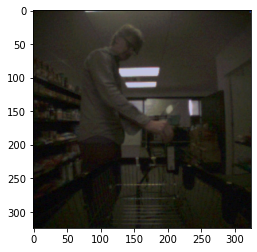

In [31]:
img_path = "/app/data/images/small_set/93539258_1696279197585_78185794_0_00_0000.jpg"
o_img = Image.open(img_path)
nparr = np.array(o_img) 
plt.imshow(nparr)

In [21]:
img_path = "/app/data/images/small_set/93539258_1696279197585_78185794_0_00_0000.jpg"
img = tf.io.read_file(img_path)
img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
img = tf.image.resize(img, (640,640))
img

<tf.Tensor: shape=(640, 640, 3), dtype=float32, numpy=
array([[[0.10196079, 0.07450981, 0.0509804 ],
        [0.09890932, 0.07349265, 0.04996324],
        [0.09295344, 0.07150736, 0.04797795],
        ...,
        [0.09712011, 0.06599265, 0.35471815],
        [0.09513479, 0.05606606, 0.39243922],
        [0.09411766, 0.0509804 , 0.41176474]],

       [[0.10196079, 0.07450981, 0.04691177],
        [0.09917314, 0.0740203 , 0.04615844],
        [0.0937322 , 0.07306488, 0.04468808],
        ...,
        [0.09      , 0.06820179, 0.35214347],
        [0.08801468, 0.06084991, 0.3908944 ],
        [0.08699755, 0.05708334, 0.4107476 ]],

       [[0.10196079, 0.07450981, 0.03897059],
        [0.09968808, 0.07505017, 0.03873219],
        [0.09525219, 0.07610486, 0.03826689],
        ...,
        [0.07610294, 0.0725136 , 0.3471182 ],
        [0.07411762, 0.07018705, 0.38787928],
        [0.07310049, 0.0689951 , 0.40876228]],

       ...,

       [[0.02745098, 0.03345589, 0.        ],
        [0.02

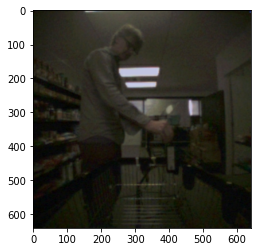

In [20]:

import matplotlib.pyplot as plt# img = Image.fromarray(array)
plt.imshow(img.numpy())

In [14]:
# Create model inside the strategy scope
with strategy.scope():
    # Create and compile the model
    model = yolo(640)
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
    optimizer = tf.keras.optimizers.Adam()

# Define checkpoint directory
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

# Define training step
@tf.function
def distributed_train_step(x, y):
    per_replica_losses = strategy.run(train_step, args=(x, y,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

def train_step(x, y):
    images, labels = x, y
    with tf.GradientTape() as tape:
        predictions = model(images)
        iou_loss, conf_loss, prob_loss = yolo_loss(predictions, labels)
        total_loss = iou_loss + conf_loss + prob_loss
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


for epoch in range(epochs):
    total_loss = 0.0
    num_batches = 0
    for x, y in train_dataset:
        total_loss += distributed_train_step(x)
        num_batches += 1
    train_loss = total_loss / num_batches
    
    # learning rate decay
    if epoch == 3:
        optimizer.lr = 1e-3
    elif epoch == 10:
        optimizer.lr = 1e-4
        
    # save checkpoint 
    if epoch % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
        
    # eval checkpoint 
    if epoch % 2 == 0:
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
        print('\nTest accuracy:', test_acc)
    
    print('Epoch {}, Loss: {}'.format(epoch, train_loss))
    
# Evaluate the model
# test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
# print('\nTest accuracy:', test_acc)

NameError: name 'epochs' is not defined